In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
import os

# Add the parent directory to the path to import from src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..')))

from src.forecaster import MultivariateForecaster
from src.features._data_processor import DataProcessor

In [3]:
# Load the data from silver layer
data_path = '../../data/silver/forecast_data.csv'
df = pd.read_csv(data_path, index_col=0)

# Display the first few rows
display(df.head())

,Client_1,year,hour,is_business_hour,month,day_of_week,is_weekend,hour_sin,hour_cos,day_of_week_sin,...,lag_1,lag_24,diff_1,pct_change_1,diff_24,pct_change_24,rolling_mean_3,rolling_std_3,rolling_mean_7,rolling_std_7
2011-01-01 00:00:00,0.0,2011,0,0,1,5,1,0.000000,1.000000,-0.974928,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2011-01-01 01:00:00,0.0,2011,1,0,1,5,1,0.258819,0.965926,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.0,2011,2,0,1,5,1,0.500000,0.866025,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2011-01-01 03:00:00,0.0,2011,3,0,1,5,1,0.707107,0.707107,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0
2011-01-01 04:00:00,0.0,2011,4,0,1,5,1,0.866025,0.500000,-0.974928,...,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [4]:
# Filter the DataFrame to keep only data from June 2012 onwards
df = df[df.index >= '2011-12-01']

# Display the updated DataFrame info
print(f"Data shape after filtering: {df.shape}")
print(f"Date range after filtering: {df.index.min()} to {df.index.max()}")

Data shape after filtering: (27049, 34)
Date range after filtering: 2011-12-01 00:00:00 to 2015-01-01 00:00:00


In [5]:
# Ensure the date column is in datetime format and set it as index
df = DataProcessor.prepare_time_index(df)

# Display basic info about the data
print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Available columns: {df.columns.tolist()}")

Data shape: (27049, 34)
Date range: 2011-12-01 00:00:00 to 2015-01-01 00:00:00
Available columns: ['Client_1', 'year', 'hour', 'is_business_hour', 'month', 'day_of_week', 'is_weekend', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year', 'week_of_year', 'quarter', 'is_month_start', 'is_month_end', 'time_of_day', 'is_morning', 'is_afternoon', 'is_evening', 'is_night', 'is_holiday', 'lag_1', 'lag_24', 'diff_1', 'pct_change_1', 'diff_24', 'pct_change_24', 'rolling_mean_3', 'rolling_std_3', 'rolling_mean_7', 'rolling_std_7']


In [6]:
# ===============================
# 2. Data Cleaning and Preprocessing
# ===============================

# Use the DataProcessor to clean the data
df = DataProcessor.clean_data(df, threshold=1e9)

Checking for problematic values in the dataset:
NaN values count: 1490
Infinity values count: 99

Data statistics:
           Client_1          year          hour  is_business_hour  \
count  27049.000000  27049.000000  27049.000000      27049.000000   
mean      20.589537   2012.944175     11.499575          0.333321   
std       24.092018      0.869300      6.922540          0.471409   
min        0.000000   2011.000000      0.000000          0.000000   
25%        6.345178   2012.000000      5.000000          0.000000   
50%        8.883249   2013.000000     11.000000          0.000000   
75%       19.035533   2014.000000     17.000000          1.000000   
max      138.324873   2015.000000     23.000000          1.000000   

              month  day_of_week    is_weekend      hour_sin      hour_cos  \
count  27049.000000      27049.0  27049.000000  2.704900e+04  2.704900e+04   
mean       6.672372          3.0      0.285704 -1.388959e-17  3.696994e-05   
std        3.517421          

In [6]:
# ===============================
# 3. Initialize and Optimize Forecaster
# ===============================

# Set parameters for the forecaster
initial_window = 8760  # One full year of hourly data to capture all seasonal patterns
step_length = 168*30     # One week of data (24 hours × 7 days) for regular model updates
forecast_horizon = np.arange(1, 25*7)  # Forecast horizon of 24 steps (one full day ahead)

# Initialize the forecaster
forecaster = MultivariateForecaster(
    data=df,
    target_columns=["Client_1"],
    config_path="../../config/small_mv_config.json",
    initial_window=initial_window,
    step_length=step_length,
    fh=forecast_horizon
)


🕒 PREPARING DATETIME INDEX
   Converting index to datetime...
✓ Successfully converted to DatetimeIndex


In [ ]:
# Run optimization to find the best model
# This may take some time depending on n_trials
n_trials = 10  # Number of trials for optimization
n_jobs = -1    # Use all available cores

print("Starting model optimization...")
forecast = forecaster.optimize(n_trials=n_trials, n_jobs=n_jobs)
print("Optimization complete!")

# Display the best model parameters
print("Best model parameters:")
best_params = forecaster.study.best_params
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest model performance (RMSE): {forecaster.study.best_value:.4f}")

[I 2025-04-02 22:11:30,533] A new study created in memory with name: no-name-9c450444-4fd8-4d37-a4c2-0e5c3755686b


Starting model optimization...


In [ ]:
# ===============================
# 4. Generate and Visualize Forecasts
# ===============================
# Generate forecasts for the next time periods
forecast = forecaster.forecast(forecast_horizon)
print("Forecasts:")
print(forecast)

Forecasts:
                     Client_1
2015-01-01 01:00:00  3.513133
2015-01-01 02:00:00  5.843139
2015-01-01 03:00:00  7.246409
2015-01-01 04:00:00  7.323681
2015-01-01 05:00:00  7.478017
...                       ...
2015-01-08 02:00:00  9.178741
2015-01-08 03:00:00  8.786723
2015-01-08 04:00:00  9.082205
2015-01-08 05:00:00  9.093223
2015-01-08 06:00:00  8.657905

[174 rows x 1 columns]


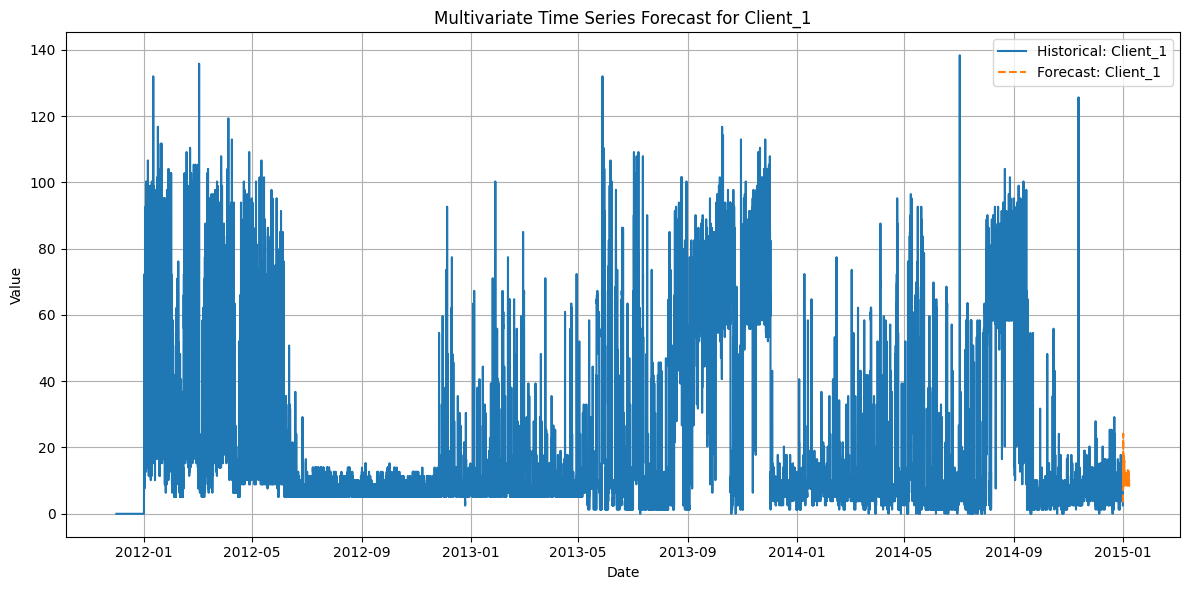

In [ ]:
# Plot the historical data and forecasts for the column 'Client_1'
plt.figure(figsize=(12, 6))

if 'Client_1' in df.columns:
    plt.plot(df.index, df['Client_1'], label='Historical: Client_1')
if 'Client_1' in forecast.columns:
    plt.plot(forecast.index, forecast['Client_1'], label='Forecast: Client_1', linestyle='--')

plt.title('Multivariate Time Series Forecast for Client_1')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# ===============================
# 5. Save the Results
# ===============================

# Save the forecasts to a CSV file
output_path = '../../data/gold/multivariate_forecasting_results.csv'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
forecast.to_csv(output_path)
print(f"Forecasts saved to {output_path}")